AIM: To train MobileNetV3Small model on different parameters.

In [ ]:
# Note: Comment or delete the current code block if dataset is loaded from local disk.
# loading dataset from kaggle
# upload kaggle.json file
! pip install -q kaggle
from google.colab import files
print("Upload 'kaggle.json' file...")
files.upload()

# download the dataset(zipped folder) and unzip it
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alessiocorrado99/animals10
! unzip animals10.zip

In [ ]:
# Note: Load the class files into current working directory.
# importing required libraries
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

from keras.callbacks import ModelCheckpoint

from imutils import paths
import matplotlib.pyplot as plt
import os

import mobilenetv3s # class file
import helper_functions # class file

In [ ]:
# defining image size and batch size
batch_size=64
image_width=224
image_height=224

In [ ]:
# getting output class labels and calculating class weight
class_labels = sorted(os.listdir('raw-img')) # get class labels
print('\nClass Labels: {}'.format(class_labels))
num_classes = len(class_labels) # get number of output classes
print('\nNumber of Classes: {}'.format(num_classes))

# calculating total elements in each class
class_totals = [len(os.listdir('raw-img' + f"/{label}")) for label in class_labels]
print("\nTotal Elements in Each Class : {}".format(class_totals))

# calculate class weight
class_weight = {i:round((max(class_totals) / class_total), 3) for i, class_total in enumerate(class_totals)}
print('\nClass Weight: {}'.format(class_weight))


Class Labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

Number of Classes: 10

Total Elements in Each Class : [4863, 2623, 1446, 2112, 3098, 1668, 1866, 1820, 4821, 1862]

Class Weight: {0: 1.0, 1: 1.854, 2: 3.363, 3: 2.303, 4: 1.57, 5: 2.915, 6: 2.606, 7: 2.672, 8: 1.009, 9: 2.612}


In [ ]:
# get image paths and move them into train and validation directories
imagePaths = list(paths.list_images("raw-img")) # getting path to the directory of images
print('Processing...')
helper_functions.move_images(imagePaths=imagePaths) # calling function
print('Completed...')

Processing...
Completed...


In [ ]:
# get training dataset
train_ds = image_dataset_from_directory(
  "train_dir/", label_mode='categorical', seed=42, shuffle=True,
  image_size=(image_height, image_width),
  batch_size=batch_size)

# get validation dataset
val_ds = image_dataset_from_directory(
  "valid_dir/", label_mode='categorical', seed=42, shuffle=True,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 18325 files belonging to 10 classes.
Found 7854 files belonging to 10 classes.


In [ ]:
# using buffered prefetching
shuffle_size = len(train_ds) # shuffles entire train dataset at each epoch

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(shuffle_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Model 1:**

      INPUT => MobileNetV3Small => GAP => DO => SOFTMAX

Observations:



1.   Trainable parameters: 5,770.
2.   Even after 100 epochs validation loss is lower than training loss.
    * Trend: Training loss is reducing slowly.
    * Training for more epochs may results in a good model.
    * Model is taking more time to learn might be due to the fact that it is not too deep or densed, i.e., fewer parameters.





4334752/4334752 [==============================] - 0s 0us/step
Model Summary...
Model: "MobileNetV3Small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 10)                5770      
                                    

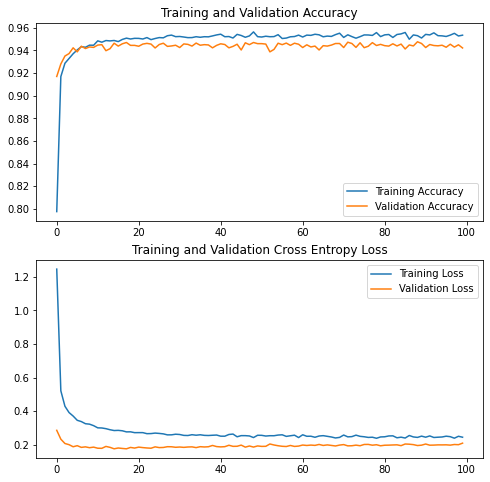

In [ ]:
# defining model architecture, subsequent training, and plotting graphs
# building the model
model = mobilenetv3s.MobileNetV3S.build(width=image_width, height=image_height, depth=3,
                                        classes=num_classes, data_aug=False, dense_layer=False)

# compiling and summarizing the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print('Model Summary...')
model.summary()

# defining callback - checkpoint
checkpoint = ModelCheckpoint('Models/MobileNetV3S_Basic/mobilenetv3s_basic_{epoch:02d}_{val_loss:.3f}.h5', monitor='val_loss', 
                             mode='min', verbose=0, save_freq='epoch')
# total epochs
epochs = 100

# training the model on defined parameters
print('\n\nModel Training...')
history = model.fit(
  train_ds, validation_data=val_ds, class_weight=class_weight, epochs=epochs, verbose=1,
  batch_size=batch_size, callbacks=[checkpoint] 
)

# plot accuracy and loss graphs of the trained model
print('\n\nModel Graphs...')
fig = helper_functions.plot_graphs(history=history)
plt.show()

**Model 2:**

      INPUT => MobileNetV3Small => GAP => FC => DO => SOFTMAX

Observations:



1.   Trainable parameters: 75,146.
2.   Best epoch: 7
    *   loss: 0.1769 - accuracy: 0.9687 - val_loss: 0.1780 - val_accuracy: 0.9459
3.   Overfitting starts from epoch 8.





Model Summary...
Model: "MobileNetV3Small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 128)               73856     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (Non

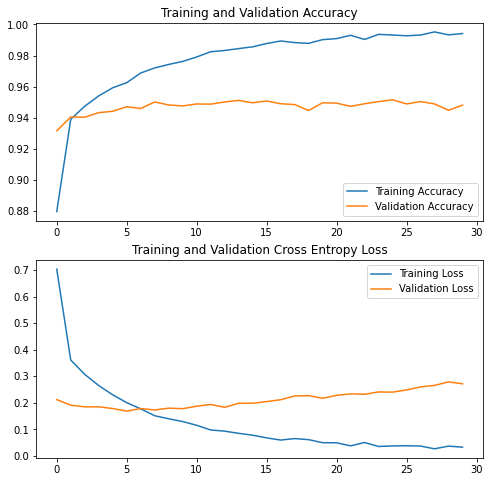

In [ ]:
# defining model architecture, subsequent training, and plotting graphs
# building the model
model = mobilenetv3s.MobileNetV3S.build(width=image_width, height=image_height, depth=3,
                                        classes=num_classes, data_aug=False, dense_layer=True)

# compiling and summarizing the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print('Model Summary...')
model.summary()

# defining callback - checkpoint
checkpoint = ModelCheckpoint('Models/MobileNetV3S_Dense/mobilenetv3s_dense_{epoch:02d}_{val_loss:.3f}.h5', monitor='val_loss', 
                             mode='min', verbose=0, save_freq='epoch')
# total epochs
epochs = 30

# training the model on defined parameters
print('\n\nModel Training...')
history = model.fit(
  train_ds, validation_data=val_ds, class_weight=class_weight, epochs=epochs, verbose=1,
  batch_size=batch_size, callbacks=[checkpoint] 
)

# plot accuracy and loss graphs of the trained model
print('\n\nModel Graphs...')
fig = helper_functions.plot_graphs(history=history)
plt.show()

**Model 3:**

      INPUT => AUGMENTATION => MobileNetV3Small => GAP => DO => SOFTMAX

Observations:



1.   Trainable parameters: 5,770.
2.   Validation loss is always lower than training loss.
    *   Probable Reason: Due to the use of data augmentation technique, the model might be seeing harder examples while training. 






Model Summary...
Model: "MobileNetV3Small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (Non

287/287 [==============================] - 95s 313ms/step - loss: 1.4805 - accuracy: 0.7483 - val_loss: 0.2826 - val_accuracy: 0.9147
Epoch 2/30
287/287 [==============================] - 90s 314ms/step - loss: 0.7606 - accuracy: 0.8719 - val_loss: 0.2332 - val_accuracy: 0.9273
Epoch 3/30
287/287 [==============================] - 89s 310ms/step - loss: 0.6628 - accuracy: 0.8869 - val_loss: 0.2181 - val_accuracy: 0.9298
Epoch 4/30
287/287 [==============================] - 90s 315ms/step - loss: 0.6345 - accuracy: 0.8886 - val_loss: 0.2020 - val_accuracy: 0.9357
Epoch 5/30
287/287 [==============================] - 89s 311ms/step - loss: 0.6150 - accuracy: 0.8916 - val_loss: 0.2027 - val_accuracy: 0.9358
Epoch 6/30
287/287 [==============================] - 90s 313ms/step - loss: 0.5738 - accuracy: 0.8992 - val_loss: 0.2065 - val_accuracy: 0.9323
Epoch 7/30
287/287 [==============================] - 89s 309ms/step - loss: 0.5666 - accuracy: 0.8995 - val_loss: 0.1895 - val_accuracy: 0.9

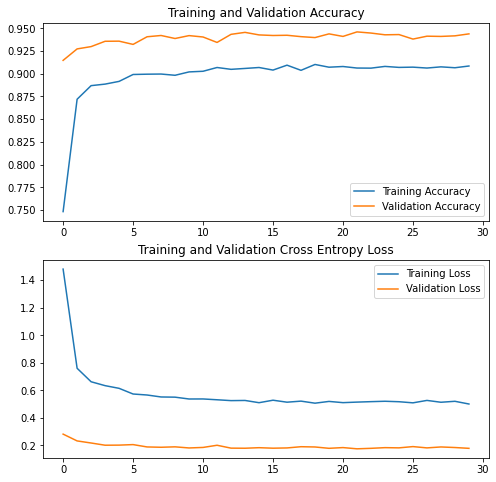

In [ ]:
# defining model architecture, subsequent training, and plotting graphs
# building the model
model = mobilenetv3s.MobileNetV3S.build(width=image_width, height=image_height, depth=3,
                                        classes=num_classes, data_aug=True, dense_layer=False)

# compiling and summarizing the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print('Model Summary...')
model.summary()

# defining callback - checkpoint
checkpoint = ModelCheckpoint('Models/MobileNetV3S_Aug/mobilenetv3s_aug_{epoch:02d}_{val_loss:.3f}.h5', monitor='val_loss', 
                             mode='min', verbose=0, save_freq='epoch')
# total epochs
epochs = 30

# training the model on defined parameters
print('\n\nModel Training...')
history = model.fit(
  train_ds, validation_data=val_ds, class_weight=class_weight, epochs=epochs, verbose=1,
  batch_size=batch_size, callbacks=[checkpoint] 
)

# plot accuracy and loss graphs of the trained model
print('\n\nModel Graphs...')
fig = helper_functions.plot_graphs(history=history)
plt.show()

**Model 4:**

      INPUT => AUGMENTATION => MobileNetV3Small => GAP => FC => DO => SOFTMAX

Observations:



1.   Trainable parameters: 75,146.
2.   Validation loss is lower than training loss.
    * Trend: Training loss is reducing slowly.
    * Training for more epochs may results in a good model.
    * Model is taking more time to learn might be due to the fact that it is not too deep or densed, i.e., fewer parameters. 






Model Summary...
Model: "MobileNetV3Small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               73856     
                                                                 
 dropout_4 (Dropout)         (Non

287/287 [==============================] - 95s 315ms/step - loss: 0.9782 - accuracy: 0.8291 - val_loss: 0.2297 - val_accuracy: 0.9241
Epoch 2/25
287/287 [==============================] - 90s 312ms/step - loss: 0.6113 - accuracy: 0.8938 - val_loss: 0.1937 - val_accuracy: 0.9371
Epoch 3/25
287/287 [==============================] - 89s 312ms/step - loss: 0.5397 - accuracy: 0.9059 - val_loss: 0.1821 - val_accuracy: 0.9424
Epoch 4/25
287/287 [==============================] - 89s 311ms/step - loss: 0.5188 - accuracy: 0.9060 - val_loss: 0.1759 - val_accuracy: 0.9436
Epoch 5/25
287/287 [==============================] - 90s 314ms/step - loss: 0.4839 - accuracy: 0.9130 - val_loss: 0.1969 - val_accuracy: 0.9363
Epoch 6/25
287/287 [==============================] - 89s 311ms/step - loss: 0.4639 - accuracy: 0.9164 - val_loss: 0.1895 - val_accuracy: 0.9388
Epoch 7/25
287/287 [==============================] - 89s 310ms/step - loss: 0.4403 - accuracy: 0.9205 - val_loss: 0.1893 - val_accuracy: 0.9

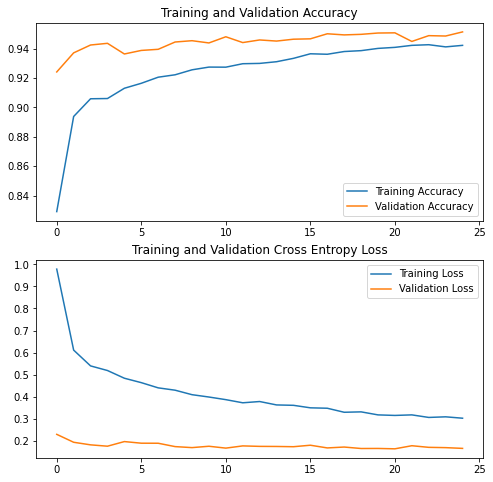

In [ ]:
# defining model architecture, subsequent training, and plotting graphs
# building the model
model = mobilenetv3s.MobileNetV3S.build(width=image_width, height=image_height, depth=3,
                                        classes=num_classes, data_aug=True, dense_layer=True)

# compiling and summarizing the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print('Model Summary...')
model.summary()

# defining callback - checkpoint
checkpoint = ModelCheckpoint('Models/MobileNetV3S_Aug_Dense/mobilenetv3s_aug_dense_{epoch:02d}_{val_loss:.3f}.h5', monitor='val_loss', 
                             mode='min', verbose=0, save_freq='epoch')
# total epochs
epochs = 25

# training the model on defined parameters
print('\n\nModel Training...')
history = model.fit(
  train_ds, validation_data=val_ds, class_weight=class_weight, epochs=epochs, verbose=1,
  batch_size=batch_size, callbacks=[checkpoint] 
)

# plot accuracy and loss graphs of the trained model
print('\n\nModel Graphs...')
fig = helper_functions.plot_graphs(history=history)
plt.show()

**Conclusion:**



1.   Epoch 7 of Model 2 gives the best results. However, the results are not as good as given by best model from MobileNetV3Large.
2.   If model is taking more time to learn, then it might be due to the fact that it is not too deep or densed, i.e., fewer parameters.